# Updated Predictions Notebook

## Prepare Notebook and Load Data

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import datetime as dt
import xgboost as xgb
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
import copy

np.set_printoptions(precision=4)

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('use_inf_as_na', True)

In [2]:
# Import Data
races = pd.read_csv('./f1db_csv/races.csv')
results = pd.read_csv('./f1db_csv/results.csv')
qualifying = pd.read_csv('./f1db_csv/qualifying.csv')
driver_standings = pd.read_csv('./f1db_csv/driver_standings.csv')
constructor_standings = pd.read_csv('./f1db_csv/constructor_standings.csv')
constructors = pd.read_csv('./f1db_csv/constructors.csv')
drivers = pd.read_csv('./f1db_csv/drivers.csv')
driver_history = pd.read_csv('./f1db_csv/driver_history.csv')
lap_times = pd.read_csv('./f1db_csv/lap_times.csv')

### Get Weather Data from Wikipedia

In [3]:
# Scrape weather
weather = races.iloc[:,[0,1,2]]

# Scrape data for weather
info = []

for link in races.url:
    try:
        df = pd.read_html(link)[0]
        if 'Weather' in list(df.iloc[:,0]):
            n = list(df.iloc[:,0]).index('Weather')
            info.append(df.iloc[n,1])
        else:
            df = pd.read_html(link)[1]
            if 'Weather' in list(df.iloc[:,0]):
                n = list(df.iloc[:,0]).index('Weather')
                info.append(df.iloc[n,1])
            else:
                df = pd.read_html(link)[2]
                if 'Weather' in list(df.iloc[:,0]):
                    n = list(df.iloc[:,0]).index('Weather')
                    info.append(df.iloc[n,1])
                else:
                    df = pd.read_html(link)[3]
                    if 'Weather' in list(df.iloc[:,0]):
                        n = list(df.iloc[:,0]).index('Weather')
                        info.append(df.iloc[n,1])
                    else:
                        driver = webdriver.Chrome()
                        driver.get(link)

                        # click language button
                        button = driver.find_element_by_link_text('Italiano')
                        button.click()
                        
                        clima = driver.find_element_by_xpath('//*[@id="mw-content-text"]/div/table[1]/tbody/tr[9]/td').text
                        info.append(clima) 
                                
    except:
        info.append('not found')

In [3]:
weather = pd.read_csv("./f1db_csv/weather.csv")

In [5]:
# Create a df just for weather and clean it up
weather["weather"].iloc[1021] = "Warm, Sunny"
weather["weather"].iloc[1022] = "Warm, Sunny"
weather["weather"].iloc[1023] = "Warm, Sunny"
weather["weather"].iloc[1024] = "Rain, Cloudy"
weather["weather"].iloc[1025] = "Warm, Sunny"
weather["weather"].iloc[1026] = "Warm, Sunny"
weather["weather"].iloc[1027] = "Warm, Sunny"

weather_dict = {'weather_warm': ['soleggiato', 'clear', 'warm', 'hot', 'sunny', 'fine', 'mild', 'sereno'],
               'weather_cold': ['cold', 'fresh', 'chilly', 'cool'],
               'weather_dry': ['dry', 'asciutto'],
               'weather_wet': ['showers', 'wet', 'rain', 'pioggia', 'damp', 'thunderstorms', 'rainy'],
               'weather_cloudy': ['overcast', 'nuvoloso', 'clouds', 'cloudy', 'grey', 'coperto']}

weather_df = pd.DataFrame(columns = weather_dict.keys())

for col in weather_df:
    weather_df[col] = weather['weather'].map(lambda x: 1 if any(i in weather_dict[col] for i in x.lower().split()) else 0)

weather_info = pd.concat([weather, weather_df], axis = 1)
weather_info
weather_info.tail(15)

,Unnamed: 0,raceId,year,round,weather,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy
1020,1020,1033,2020,3,Partly cloudy,0,0,0,0,1,0,0,0,0,1
1021,1021,1034,2020,4,"Warm, Sunny",1,0,0,0,0,1,0,0,0,0
1022,1022,1035,2020,5,"Warm, Sunny",1,0,0,0,0,1,0,0,0,0
1023,1023,1036,2020,6,"Warm, Sunny",1,0,0,0,0,1,0,0,0,0
1024,1024,1037,2020,7,"Rain, Cloudy",0,0,0,0,1,0,0,0,0,1
1025,1025,1038,2020,8,"Warm, Sunny",1,0,0,0,0,1,0,0,0,0
1026,1026,1039,2020,9,"Warm, Sunny",1,0,0,0,0,1,0,0,0,0
1027,1027,1040,2020,10,"Warm, Sunny",1,0,0,0,0,1,0,0,0,0
1028,1028,1041,2020,11,not found,0,0,0,0,0,0,0,0,0,0
1029,1029,1042,2020,12,not found,0,0,0,0,0,0,0,0,0,0


In [6]:
# Write this to a csv to be used later
weather_info.to_csv("./f1db_csv/weather.csv")

In [7]:
weather = pd.read_csv("./f1db_csv/weather.csv")

## Create Tables for Predictions

In [6]:
# Merge together to create final df for predictions
df1 = pd.merge(races, weather[["raceId", "weather_warm", "weather_cold", "weather_dry", "weather_wet", "weather_cloudy"]], on=['raceId'], how = "left")
df2 = pd.merge(df1, results[["raceId", "driverId", "constructorId", "grid", "position", "points", "milliseconds", "laps", "fastestLapSpeed"]], on=['raceId'], how = "left")
df2 = df2.rename({'position' : 'finishingPosition', 'points' : 'pointsGained'}, axis = 1)
df3 = pd.merge(df2, driver_standings[["raceId", "driverId", "points", "position", "wins"]], on=['raceId', 'driverId'], how = "left")
df3 = df3.rename({'position' : 'driverStanding', 'points' : 'cumulativePoints', 'wins' : 'driver_wins'}, axis = 1)
df4 = pd.merge(df3, constructor_standings[["raceId", "constructorId", "points", "position", "wins"]], how='left', on=['raceId', 'constructorId']) #from 1958
df4 = df4.rename({'position' : 'constructorStanding', 'points' : 'constructorPoints', 'wins' : 'constructorWins', 'name' : 'raceName'}, axis = 1)
df5 = pd.merge(df4, constructors[["constructorId", "name"]], on = "constructorId", how = "left")
df5 = df5.rename({'name' : 'constructorName'}, axis = 1)

# Match drivers in driver history table to their driver IDs
drivers["driverName"] = drivers["forename"].str.cat(drivers["surname"],sep = " ")
df6 = pd.merge(driver_history, drivers[["driverName", "driverId"]], on = "driverName", how = "left")

final_df = pd.merge(df5, df6[["raceId", "driverId", "minQualifyingTime", "fastestLapTime"]], on=['raceId', 'driverId'], how = "left")
final_df = final_df.drop(columns = ["round", "circuitId", "time", "url", "constructorId"])

# Rearrange the columns so identifying information is at the beginning
key = lambda x: (x != 'raceId', x != 'date', x != 'year', x != 'raceName', x != 'driverId', x != 'finishingPosition')
final_df = final_df[sorted(final_df, key=key)]

In [7]:
# Get dummies for categorical variables
df_dum = pd.get_dummies(final_df, columns = ['constructorName'])
# Convert date to datetime
df_dum["date"] = pd.to_datetime(df_dum["date"])
df_dum = df_dum.sort_values("date", ascending = True)

In [8]:
# Merge lap times data
total_lap_times = pd.merge(lap_times, races[["raceId", "year"]], on = "raceId")
total_lap_times = total_lap_times[["raceId", "driverId", "milliseconds"]]
total_lap_times = total_lap_times.groupby(['raceId', 'driverId']).sum()
total_lap_times["seconds"] = total_lap_times.milliseconds / 1000

# Merge in the seconds for each race
df_dum_merged = pd.merge(df_dum, total_lap_times, on = ["raceId", "driverId"])
df_dum_merged = df_dum_merged.drop(columns = ["milliseconds_x", "milliseconds_y"])

# Look only at 2020 data right now
df_2020 = df_dum_merged[df_dum_merged.year == 2020]

# Drop teams that didn't exist in 2020
for col in df_2020.columns:
    if 'constructorName' in col and df_2020[col].sum() < 1:
        df_2020.drop(col, axis = 1, inplace = True)

df_2020 = df_2020.sort_values(["date", "driverId"], ascending = True)
df_2020

,raceId,date,year,raceName,driverId,finishingPosition,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,minQualifyingTime,fastestLapTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,seconds
8974,1031,2020-07-05,2020,Austrian Grand Prix,1.0,4,1,0,0,0,0,5.0,12.0,71.0,229.572,12.0,4.0,0.0,37.0,1.0,1.0,62.951,67.712,0,0,0,0,0,1,0,0,0,0,5456.428
8965,1031,2020-07-05,2020,Austrian Grand Prix,8.0,\N,1,0,0,0,0,19.0,0.0,53.0,225.185,0.0,14.0,0.0,2.0,7.0,0.0,65.224,69.031,1,0,0,0,0,0,0,0,0,0,3980.856
8969,1031,2020-07-05,2020,Austrian Grand Prix,20.0,10,1,0,0,0,0,11.0,1.0,71.0,226.524,1.0,10.0,0.0,19.0,3.0,0.0,64.206,68.623,0,0,1,0,0,0,0,0,0,0,5480.284
8963,1031,2020-07-05,2020,Austrian Grand Prix,154.0,\N,1,0,0,0,0,15.0,0.0,49.0,221.347,0.0,16.0,0.0,0.0,10.0,0.0,64.691,70.228,0,0,0,1,0,0,0,0,0,0,3695.277
8972,1031,2020-07-05,2020,Austrian Grand Prix,815.0,6,1,0,0,0,0,6.0,8.0,71.0,227.579,8.0,6.0,0.0,8.0,4.0,0.0,63.860,68.305,0,0,0,0,0,0,1,0,0,0,5465.831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9126,1039,2020-09-13,2020,Tuscan Grand Prix,844.0,8,1,0,0,0,0,5.0,4.0,59.0,232.453,49.0,8.0,0.0,66.0,6.0,0.0,76.270,81.229,0,0,1,0,0,0,0,0,0,0,8403.405
9128,1039,2020-09-13,2020,Tuscan Grand Prix,846.0,6,1,0,0,0,0,11.0,8.0,59.0,232.542,65.0,4.0,0.0,106.0,3.0,0.0,76.640,81.198,0,0,0,0,1,0,0,0,0,0,8393.943
9117,1039,2020-09-13,2020,Tuscan Grand Prix,847.0,11,1,0,0,0,0,18.0,0.0,59.0,231.269,0.0,20.0,0.0,0.0,10.0,0.0,77.232,81.645,0,0,0,0,0,0,0,0,0,1,8407.464
9131,1039,2020-09-13,2020,Tuscan Grand Prix,848.0,3,1,0,0,0,0,4.0,15.0,59.0,235.909,63.0,5.0,0.0,173.0,2.0,1.0,75.914,80.039,0,0,0,0,0,0,0,1,0,0,8383.124


In [9]:
# Reformat the data so that it's taking info from the previous race
# Separate the data from the current race and the previous race
current_df = df_2020[["raceId", "date", "year", "raceName", "driverId", "finishingPosition", "seconds", "weather_warm", "weather_cold", 
                      "weather_dry", "weather_wet", "weather_cloudy", "grid", "minQualifyingTime", 
                      "constructorName_Alfa Romeo", "constructorName_AlphaTauri", "constructorName_Ferrari", 
                      "constructorName_Haas F1 Team", "constructorName_McLaren", "constructorName_Mercedes", 
                      "constructorName_Racing Point", "constructorName_Red Bull", "constructorName_Renault", 
                      "constructorName_Williams"]]
current_df = current_df.rename({'finishingPosition' : 'currentFinishingPosition', 'grid' : 'qualiPosition'}, axis = 1)
past_df = df_2020[["raceId", "date", "year", "raceName", "driverId", "finishingPosition", "laps", "pointsGained", 
                   "fastestLapSpeed", "cumulativePoints", "driverStanding", "driver_wins", "constructorPoints", "constructorStanding",
                   "constructorWins", "fastestLapTime"]]
past_df = past_df.rename({'finishingPosition' : 'pastFinishingPosition', 'pointsGained' : 'pastPointsGained'}, axis = 1)

# Change raceId for the past races so that info from the previous race gets matched to the current race for preds
past_df["raceId"] = past_df["raceId"] + 1

# Merge the two together for predictions
full_df = pd.merge(current_df, past_df[["raceId", "driverId", "laps", "pastFinishingPosition", "pastPointsGained",
                                        "fastestLapSpeed", "cumulativePoints", "driverStanding", "driver_wins", 
                                        "constructorPoints", "constructorStanding", "constructorWins", "fastestLapTime"]],
                   on = ["raceId", "driverId"], how = "left")

# Create variable for the difference between qualifying position and finishing position
full_df = full_df.replace({r"\N": None, "NaN" : None})
# full_df["finishingPosition"] = pd.to_numeric(full_df["finishingPosition"])
# full_df["quali_final_delta"] = full_df["finishingPosition"] - full_df["grid"]
full_df[["driverId", "currentFinishingPosition", "pastFinishingPosition"]][full_df.raceId == 1038].sort_values("currentFinishingPosition")

,driverId,currentFinishingPosition,pastFinishingPosition
152,842.0,1,8
142,815.0,10,10
157,849.0,11,16
141,154.0,12,15
139,8.0,13,12
155,847.0,14,None
156,848.0,15,6
151,841.0,16,None
148,832.0,2,NaN
150,840.0,3,9


In [10]:
full_df

,raceId,date,year,raceName,driverId,currentFinishingPosition,seconds,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,qualiPosition,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,laps,pastFinishingPosition,pastPointsGained,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,1031,2020-07-05,2020,Austrian Grand Prix,1.0,4,5456.428,1,0,0,0,0,5.0,62.951,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1031,2020-07-05,2020,Austrian Grand Prix,8.0,None,3980.856,1,0,0,0,0,19.0,65.224,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1031,2020-07-05,2020,Austrian Grand Prix,20.0,10,5480.284,1,0,0,0,0,11.0,64.206,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1031,2020-07-05,2020,Austrian Grand Prix,154.0,None,3695.277,1,0,0,0,0,15.0,64.691,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1031,2020-07-05,2020,Austrian Grand Prix,815.0,6,5465.831,1,0,0,0,0,6.0,63.860,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,1039,2020-09-13,2020,Tuscan Grand Prix,844.0,8,8403.405,1,0,0,0,0,5.0,76.270,0,0,1,0,0,0,0,0,0,0,23.0,None,0.0,242.424,45.0,7.0,0.0,61.0,6.0,0.0,86.026
172,1039,2020-09-13,2020,Tuscan Grand Prix,846.0,6,8393.943,1,0,0,0,0,11.0,76.640,0,0,0,0,1,0,0,0,0,0,53.0,4,12.0,247.587,57.0,5.0,0.0,98.0,3.0,0.0,84.232
173,1039,2020-09-13,2020,Tuscan Grand Prix,847.0,11,8407.464,1,0,0,0,0,18.0,77.232,0,0,0,0,0,0,0,0,0,1,53.0,14,0.0,247.033,0.0,21.0,0.0,0.0,10.0,0.0,84.421
174,1039,2020-09-13,2020,Tuscan Grand Prix,848.0,3,8383.124,1,0,0,0,0,4.0,75.914,0,0,0,0,0,0,0,1,0,0,53.0,15,0.0,245.564,48.0,6.0,0.0,158.0,2.0,1.0,84.926


In [11]:
# Find the time for the fastest driver at every race
# Fastest Lap
fastest_time_df = full_df[full_df.pastFinishingPosition == "1"]
fastest_time_df = fastest_time_df[["raceId", "seconds", "laps"]]
fastest_time_df["avg_lap_time"] = fastest_time_df["seconds"] / fastest_time_df["laps"]
fastest_time_df

,raceId,seconds,laps,avg_lap_time
26,1032,4984.402,71.0,70.202845
40,1033,5772.473,71.0,81.302437
60,1034,5281.283,70.0,75.446900
79,1035,4793.319,52.0,92.179212
108,1036,5529.456,52.0,106.335692
119,1037,5048.761,66.0,76.496379
138,1038,6443.301,44.0,146.438659


In [12]:
# Delete rows where there are nans
# full_df = full_df.replace({r"\N": None})
# full_df = full_df.dropna()

# Create ratios for all the variables in terms of seconds and then create a rolling average for them over the season
min_df = full_df.groupby("raceId", as_index = False)
min_lap_time = min_df.fastestLapTime.min()
temp1 = pd.merge(full_df, min_lap_time, on = "raceId")  
temp1["fastestLapRatio"] = temp1["fastestLapTime_x"] / temp1["fastestLapTime_y"]
temp1 = temp1.drop(columns = ["fastestLapTime_x", "fastestLapTime_y"])
min_quali_time = min_df.minQualifyingTime.min()
temp2 = pd.merge(temp1, min_quali_time, on = "raceId")
temp2["minQualiRatio"] = temp2["minQualifyingTime_x"] / temp2["minQualifyingTime_y"]
temp2 = temp2.drop(columns = ["minQualifyingTime_x", "minQualifyingTime_y"])
temp2["avg_lap_time"] = temp2["seconds"] / temp2["laps"]
temp_min = temp2.groupby("raceId", as_index = False)
min_avg_lap_time = temp_min.avg_lap_time.min()
temp_min1 = pd.merge(temp2, min_avg_lap_time, on = "raceId")
temp_min1["avgLapRatio"] = temp_min1["avg_lap_time_x"] / temp_min1["avg_lap_time_y"]
temp_min1 = temp_min1.drop(columns = ["avg_lap_time_x", "avg_lap_time_y"])
temp3 = temp_min1.groupby("driverId", as_index = True)
rolling_fastLapRatio = pd.DataFrame(temp3["fastestLapRatio"].rolling(window = 50, min_periods = 1).mean())
rolling_fastLapRatio = rolling_fastLapRatio.reset_index()
rolling_fastLapRatio = rolling_fastLapRatio.rename({"level_1" : "index", "fastestLapRatio" : "rolling_fastestLap"}, axis = 1)
rolling_minQualiRatio = pd.DataFrame(temp3["minQualiRatio"].rolling(window = 50, min_periods = 1).mean())
rolling_minQualiRatio = rolling_minQualiRatio.reset_index()
rolling_minQualiRatio = rolling_minQualiRatio.rename({"level_1" : "index", "minQualiRatio" : "rolling_minQualiRatio"}, axis = 1)
rolling_avgLapRatio = pd.DataFrame(temp3["avgLapRatio"].rolling(window = 50, min_periods = 1).mean())
rolling_avgLapRatio = rolling_avgLapRatio.reset_index()
rolling_avgLapRatio = rolling_avgLapRatio.rename({"level_1" : "index", "avgLapRatio" : "rolling_avgLapTime"}, axis = 1)
temp_min1 = temp_min1.reset_index()
temp4 = pd.merge(temp_min1, rolling_fastLapRatio, on = ["driverId", "index"])
temp5 = pd.merge(temp4, rolling_minQualiRatio, on = ["driverId", "index"])
temp6 = pd.merge(temp5, rolling_avgLapRatio, on = ["driverId", "index"])
temp6 = temp6.drop(columns = ["fastestLapRatio", "minQualiRatio", "avgLapRatio", "seconds", "laps"])

key = lambda x: (x != 'index', x != 'raceId', x != 'date', x != 'year', x != 'raceName', x != 'driverId', x != 'rolling_avgLapTime')
sorted_df = temp6[sorted(temp6, key=key)]
sorted_df["rolling_avgLapTime"] = sorted_df["rolling_avgLapTime"] * 100
sorted_df["rolling_fastestLap"] = sorted_df["rolling_fastestLap"] * 100
sorted_df["rolling_minQualiRatio"] = sorted_df["rolling_minQualiRatio"] * 100
sorted_df = sorted_df.drop(columns = "rolling_avgLapTime")

,index,raceId,date,year,raceName,driverId,currentFinishingPosition,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,qualiPosition,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,pastFinishingPosition,pastPointsGained,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,rolling_fastestLap,rolling_minQualiRatio
138,138,1038,2020-09-06,2020,Italian Grand Prix,1.0,7,1,0,0,0,0,1.0,0,0,0,0,0,1,0,0,0,0,1,25.0,233.990,157.0,1.0,5.0,264.0,1.0,6.0,100.976855,100.011631
139,139,1038,2020-09-06,2020,Italian Grand Prix,8.0,13,1,0,0,0,0,14.0,1,0,0,0,0,0,0,0,0,0,12,0.0,229.593,0.0,18.0,0.0,2.0,8.0,0.0,103.718908,103.398184
140,140,1038,2020-09-06,2020,Italian Grand Prix,20.0,None,1,0,0,0,0,17.0,0,0,1,0,0,0,0,0,0,0,13,0.0,229.309,16.0,13.0,0.0,61.0,5.0,0.0,103.542403,102.206774
141,141,1038,2020-09-06,2020,Italian Grand Prix,154.0,12,1,0,0,0,0,16.0,0,0,0,1,0,0,0,0,0,0,15,0.0,229.184,0.0,21.0,0.0,1.0,9.0,0.0,103.345861,103.137817
142,142,1038,2020-09-06,2020,Italian Grand Prix,815.0,10,1,0,0,0,0,4.0,0,0,0,0,0,0,1,0,0,0,10,1.0,232.628,33.0,9.0,0.0,66.0,4.0,0.0,102.501233,101.887260
143,143,1038,2020-09-06,2020,Italian Grand Prix,817.0,6,1,0,0,0,0,7.0,0,0,0,0,0,0,0,0,1,0,4,13.0,234.589,33.0,8.0,0.0,59.0,6.0,0.0,103.299351,101.759943
144,144,1038,2020-09-06,2020,Italian Grand Prix,822.0,5,1,0,0,0,0,2.0,0,0,0,0,0,1,0,0,0,0,2,18.0,233.503,107.0,3.0,1.0,264.0,1.0,6.0,101.283235,100.281396
145,145,1038,2020-09-06,2020,Italian Grand Prix,825.0,None,1,0,0,0,0,15.0,0,0,0,1,0,0,0,0,0,0,17,0.0,233.287,1.0,17.0,0.0,1.0,9.0,0.0,103.881753,103.237648
146,146,1038,2020-09-06,2020,Italian Grand Prix,826.0,9,1,0,0,0,0,11.0,0,1,0,0,0,0,0,0,0,0,11,0.0,229.572,2.0,16.0,0.0,20.0,7.0,0.0,104.074585,102.483344
147,147,1038,2020-09-06,2020,Italian Grand Prix,830.0,None,1,0,0,0,0,5.0,0,0,0,0,0,0,0,1,0,0,3,15.0,232.809,110.0,2.0,1.0,158.0,2.0,1.0,101.863313,100.988691


In [72]:
sorted_df[sorted_df.driverId == 846.0]

,index,raceId,date,year,raceName,driverId,currentFinishingPosition,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,qualiPosition,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,pastFinishingPosition,pastPointsGained,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,rolling_fastestLap,rolling_minQualiRatio
36,36,1032,2020-07-12,2020,Styrian Grand Prix,846.0,5.0,1,0,0,0,0,9.0,0,0,0,0,1,0,0,0,0,0,3.0,16.0,230.378,16.0,3.0,0.0,26.0,2.0,0.0,100.000000,100.946024
56,56,1033,2020-07-19,2020,Hungarian Grand Prix,846.0,13.0,0,0,0,0,1,8.0,0,0,0,0,1,0,0,0,0,0,5.0,10.0,231.345,26.0,3.0,0.0,39.0,2.0,0.0,101.199348,101.320068
75,75,1034,2020-08-02,2020,British Grand Prix,846.0,5.0,1,0,0,0,0,5.0,0,0,0,0,1,0,0,0,0,0,13.0,0.0,197.280,26.0,4.0,0.0,41.0,3.0,0.0,102.242921,101.428648
95,95,1035,2020-08-09,2020,70th Anniversary Grand Prix,846.0,9.0,1,0,0,0,0,10.0,0,0,0,0,1,0,0,0,0,0,5.0,10.0,235.488,36.0,4.0,0.0,51.0,3.0,0.0,102.532105,101.524345
115,115,1036,2020-08-16,2020,Spanish Grand Prix,846.0,10.0,1,0,0,0,0,8.0,0,0,0,0,1,0,0,0,0,0,9.0,2.0,233.826,38.0,5.0,0.0,53.0,4.0,0.0,102.533762,101.601045
134,134,1037,2020-08-30,2020,Belgian Grand Prix,846.0,7.0,0,0,0,0,1,10.0,0,0,0,0,1,0,0,0,0,0,10.0,1.0,203.393,39.0,7.0,0.0,62.0,4.0,0.0,103.008722,101.570557
154,154,1038,2020-09-06,2020,Italian Grand Prix,846.0,4.0,1,0,0,0,0,6.0,0,0,0,0,1,0,0,0,0,0,7.0,6.0,232.279,45.0,6.0,0.0,68.0,3.0,0.0,102.720987,101.522075
172,172,1039,2020-09-13,2020,Tuscan Grand Prix,846.0,6.0,1,0,0,0,0,11.0,0,0,0,0,1,0,0,0,0,0,4.0,12.0,247.587,57.0,5.0,0.0,98.0,3.0,0.0,102.605346,101.574161


## Build the Model

In [13]:
# Split x and y in training data
sorted_df["fastestLapSpeed"] = pd.to_numeric(sorted_df["fastestLapSpeed"])
sorted_df["currentFinishingPosition"] = pd.to_numeric(sorted_df["currentFinishingPosition"])
sorted_df["pastFinishingPosition"] = pd.to_numeric(sorted_df["pastFinishingPosition"])

# Remove any NAs
sorted_df = sorted_df.replace({r"\N": None})
sorted_df = sorted_df.dropna()

x = sorted_df.iloc[:, 7:]
y = sorted_df.iloc[:, 6]

In [14]:
xgb_model = xgb.XGBRegressor(n_estimators = 300, max_depth = 9)
xgb_model.fit(x, y)
xgb_model.score(x, y)

0.9999999777748618

In [27]:
total_lap_info[total_lap_info.raceId == 1039]

,raceId,driverId,milliseconds,seconds,laps,avg_lap_time
9117,1039,1,8375060,8375.060,59.0,141.950169
9118,1039,8,8399830,8399.830,59.0,142.370000
9119,1039,20,8405043,8405.043,59.0,142.458356
9120,1039,154,8417096,8417.096,59.0,142.662644
9121,1039,815,8390710,8390.710,59.0,142.215424
9122,1039,817,8385477,8385.477,59.0,142.126729
9123,1039,822,8379940,8379.940,59.0,142.032881
9124,1039,825,676573,676.573,5.0,135.314600
9125,1039,826,8396816,8396.816,59.0,142.318915
9126,1039,832,679454,679.454,5.0,135.890800


In [34]:
# Doing the same for the most recent race, pulled in from Raw Predictive Modeling ipynb
# Merge lap times data
total_lap_times = pd.merge(lap_times, races[["raceId", "year"]], on = "raceId")
total_lap_times = total_lap_times[["raceId", "driverId", "milliseconds"]]
total_lap_times = total_lap_times.groupby(['raceId', 'driverId']).sum()
total_lap_times["seconds"] = total_lap_times.milliseconds / 1000
total_lap_info = pd.merge(total_lap_times, df_dum[["raceId", "driverId", "laps"]], on = ["raceId", "driverId"])
total_lap_info["avg_lap_time"] = total_lap_info.seconds / total_lap_info.laps
total_lap_info

test_df = pd.read_csv("./predictions/ru_2020_raw_table").iloc[:, 1:]
test_df
# past_race_lap_info = total_lap_info[total_lap_info.raceId == 1039]
# past_race_lap_info["raceId"] = past_race_lap_info["raceId"] + 1
# past_race_lap_info
# test_merged_df = pd.merge(test_df, past_race_lap_info[["raceId", "driverId", "seconds"]], on = ["raceId", "driverId"])
# test_merged_df

,raceId,driverId,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,1040,1,1,0,0,0,0,1,91.304,0,0,0,0,0,1,0,0,0,0,1.0,26.0,59.0,239.518,190.0,1.0,6.0,325.0,1.0,7.0,78.833
1,1040,822,1,0,0,0,0,3,91.956,0,0,0,0,0,1,0,0,0,0,2.0,18.0,59.0,237.712,135.0,2.0,1.0,325.0,1.0,7.0,79.432
2,1040,830,1,0,0,0,0,2,91.867,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1040,848,1,0,0,0,0,10,93.008,0,0,0,0,0,0,0,1,0,0,3.0,15.0,59.0,235.909,63.0,5.0,0.0,173.0,2.0,1.0,80.039
4,1040,815,1,0,0,0,0,4,92.317,0,0,0,0,0,0,1,0,0,0,5.0,10.0,59.0,234.175,44.0,9.0,0.0,92.0,4.0,0.0,80.632
5,1040,840,1,0,0,0,0,13,93.364,0,0,0,0,0,0,1,0,0,0,NaN,0.0,42.0,230.077,57.0,6.0,0.0,92.0,4.0,0.0,82.068
6,1040,817,1,0,0,0,0,5,92.218,0,0,0,0,0,0,0,0,1,0,4.0,12.0,59.0,234.774,53.0,7.0,0.0,83.0,5.0,0.0,80.426
7,1040,839,1,0,0,0,0,7,92.624,0,0,0,0,0,0,0,0,1,0,NaN,0.0,7.0,143.270,30.0,12.0,0.0,83.0,5.0,0.0,131.793
8,1040,832,1,0,0,0,0,6,92.550,0,0,0,0,1,0,0,0,0,0,NaN,0.0,5.0,140.802,41.0,11.0,0.0,106.0,3.0,0.0,134.103
9,1040,846,1,0,0,0,0,8,92.847,0,0,0,0,1,0,0,0,0,0,6.0,8.0,59.0,232.542,65.0,4.0,0.0,106.0,3.0,0.0,81.198


In [54]:
current_min_df = test_df.groupby("raceId", as_index = False)
current_min_lap_time = current_min_df.fastestLapTime.min()
current_temp1 = pd.merge(test_df, current_min_lap_time, on = "raceId")  
current_temp1["fastestLapRatio"] = current_temp1["fastestLapTime_x"] / current_temp1["fastestLapTime_y"]
current_temp1 = current_temp1.drop(columns = ["fastestLapTime_x", "fastestLapTime_y"])
current_min_quali_time = current_min_df.minQualifyingTime.min()
current_temp2 = pd.merge(current_temp1, current_min_quali_time, on = "raceId")
current_temp2["minQualiRatio"] = current_temp2["minQualifyingTime_x"] / current_temp2["minQualifyingTime_y"]
current_temp2 = current_temp2.drop(columns = ["minQualifyingTime_x", "minQualifyingTime_y"])
# # current_temp2["avg_lap_time"] = current_temp2["seconds"] / current_temp2["laps"]
# current_temp_min = current_temp2.groupby("raceId", as_index = False)
# # current_min_avg_lap_time = current_temp_min.avg_lap_time.min()
# current_temp_min1 = pd.merge(current_temp2, current_min_avg_lap_time, on = "raceId")
# # current_temp_min1["avgLapRatio"] = current_temp_min1["avg_lap_time_x"] / current_temp_min1["avg_lap_time_y"]
# # current_temp_min1 = current_temp_min1.drop(columns = ["avg_lap_time_x", "avg_lap_time_y"])
current_temp3 = current_temp2.groupby("driverId", as_index = True)
current_rolling_fastLapRatio = pd.DataFrame(current_temp3["fastestLapRatio"].rolling(window = 50, min_periods = 1).mean())
current_rolling_fastLapRatio = current_rolling_fastLapRatio.reset_index()
current_rolling_fastLapRatio = current_rolling_fastLapRatio.rename({"level_1" : "index", "fastestLapRatio" : "rolling_fastestLap"}, axis = 1)
current_rolling_minQualiRatio = pd.DataFrame(current_temp3["minQualiRatio"].rolling(window = 50, min_periods = 1).mean())
current_rolling_minQualiRatio = current_rolling_minQualiRatio.reset_index()
current_rolling_minQualiRatio = current_rolling_minQualiRatio.rename({"level_1" : "index", "minQualiRatio" : "rolling_minQualiRatio"}, axis = 1)
# # current_rolling_avgLapRatio = pd.DataFrame(current_temp3["avgLapRatio"].rolling(window = 50, min_periods = 1).mean())
# # current_rolling_avgLapRatio = current_rolling_avgLapRatio.reset_index()
# # current_rolling_avgLapRatio = current_rolling_avgLapRatio.rename({"level_1" : "index", "avgLapRatio" : "rolling_avgLapTime"}, axis = 1)
current_temp2 = current_temp2.reset_index()
current_temp4 = pd.merge(current_temp2, current_rolling_fastLapRatio, on = ["driverId", "index"])
current_temp5 = pd.merge(current_temp4, current_rolling_minQualiRatio, on = ["driverId", "index"])
current_temp6 = current_temp5.drop(columns = ["fastestLapRatio", "minQualiRatio", "laps"])
key = lambda x: (x != 'index', x != 'raceId', x != 'date', x != 'year', x != 'raceName', x != 'driverId')
current_sorted_df = current_temp6[sorted(current_temp6, key=key)]
current_sorted_df["rolling_fastestLap"] = current_sorted_df["rolling_fastestLap"] * 100
current_sorted_df["rolling_minQualiRatio"] = current_sorted_df["rolling_minQualiRatio"] * 100
# current_sorted_df = current_sorted_df.dropna()
current_sorted_df = current_sorted_df.rename({'finishingPosition' : 'pastFinishingPosition', 'grid' : 'qualiPosition', 'pointsGained' : 'pastPointsGained'}, axis = 1)
current_sorted_df

,index,raceId,driverId,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,qualiPosition,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,pastFinishingPosition,pastPointsGained,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,rolling_fastestLap,rolling_minQualiRatio
0,0,1040,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1.0,26.0,239.518,190.0,1.0,6.0,325.0,1.0,7.0,100.000000,100.000000
1,1,1040,822,1,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,2.0,18.0,237.712,135.0,2.0,1.0,325.0,1.0,7.0,100.759834,100.714098
2,2,1040,830,1,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.616621
3,3,1040,848,1,0,0,0,0,10,0,0,0,0,0,0,0,1,0,0,3.0,15.0,235.909,63.0,5.0,0.0,173.0,2.0,1.0,101.529816,101.866293
4,4,1040,815,1,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,5.0,10.0,234.175,44.0,9.0,0.0,92.0,4.0,0.0,102.282039,101.109480
5,5,1040,840,1,0,0,0,0,13,0,0,0,0,0,0,1,0,0,0,NaN,0.0,230.077,57.0,6.0,0.0,92.0,4.0,0.0,104.103611,102.256199
6,6,1040,817,1,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,4.0,12.0,234.774,53.0,7.0,0.0,83.0,5.0,0.0,102.020727,101.001051
7,7,1040,839,1,0,0,0,0,7,0,0,0,0,0,0,0,0,1,0,NaN,0.0,143.270,30.0,12.0,0.0,83.0,5.0,0.0,167.179988,101.445720
8,8,1040,832,1,0,0,0,0,6,0,0,0,0,1,0,0,0,0,0,NaN,0.0,140.802,41.0,11.0,0.0,106.0,3.0,0.0,170.110233,101.364672
9,9,1040,846,1,0,0,0,0,8,0,0,0,0,1,0,0,0,0,0,6.0,8.0,232.542,65.0,4.0,0.0,106.0,3.0,0.0,103.000013,101.689959


In [55]:
x_test = current_sorted_df.iloc[:, 3:]

In [56]:
x_test

,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,qualiPosition,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,pastFinishingPosition,pastPointsGained,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,rolling_fastestLap,rolling_minQualiRatio
0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1.0,26.0,239.518,190.0,1.0,6.0,325.0,1.0,7.0,100.000000,100.000000
1,1,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,2.0,18.0,237.712,135.0,2.0,1.0,325.0,1.0,7.0,100.759834,100.714098
2,1,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.616621
3,1,0,0,0,0,10,0,0,0,0,0,0,0,1,0,0,3.0,15.0,235.909,63.0,5.0,0.0,173.0,2.0,1.0,101.529816,101.866293
4,1,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,5.0,10.0,234.175,44.0,9.0,0.0,92.0,4.0,0.0,102.282039,101.109480
5,1,0,0,0,0,13,0,0,0,0,0,0,1,0,0,0,NaN,0.0,230.077,57.0,6.0,0.0,92.0,4.0,0.0,104.103611,102.256199
6,1,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,4.0,12.0,234.774,53.0,7.0,0.0,83.0,5.0,0.0,102.020727,101.001051
7,1,0,0,0,0,7,0,0,0,0,0,0,0,0,1,0,NaN,0.0,143.270,30.0,12.0,0.0,83.0,5.0,0.0,167.179988,101.445720
8,1,0,0,0,0,6,0,0,0,0,1,0,0,0,0,0,NaN,0.0,140.802,41.0,11.0,0.0,106.0,3.0,0.0,170.110233,101.364672
9,1,0,0,0,0,8,0,0,0,0,1,0,0,0,0,0,6.0,8.0,232.542,65.0,4.0,0.0,106.0,3.0,0.0,103.000013,101.689959


In [57]:
xgb_preds = xgb_model.predict(x_test)
xgb_preds_df = pd.DataFrame({'Predictions' : xgb_preds})
merged_xgb_df = pd.merge(xgb_preds_df, current_sorted_df[["raceId", "driverId"]], left_index = True, right_index = True)
full_xgb_df = pd.merge(merged_xgb_df, drivers[["driverName", "driverId"]], on = "driverId")
full_xgb_df = full_xgb_df.sort_values("Predictions")
full_xgb_df = full_xgb_df.reset_index(drop = True)
full_xgb_df["Predicted Position"] = full_xgb_df.index + 1
full_xgb_df.sort_values("Predictions")

,Predictions,raceId,driverId,driverName,Predicted Position
0,1.517110,1040,822,Valtteri Bottas,1
1,1.869646,1040,1,Lewis Hamilton,2
2,2.740350,1040,815,Sergio Pérez,3
3,3.084104,1040,817,Daniel Ricciardo,4
4,4.376818,1040,832,Carlos Sainz,5
5,4.839567,1040,839,Esteban Ocon,6
6,6.030191,1040,830,Max Verstappen,7
7,6.714252,1040,848,Alexander Albon,8
8,7.359552,1040,846,Lando Norris,9
9,8.204182,1040,826,Daniil Kvyat,10


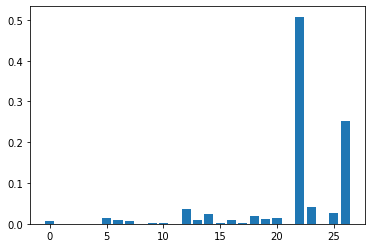

In [62]:
pyplot.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
pyplot.show()

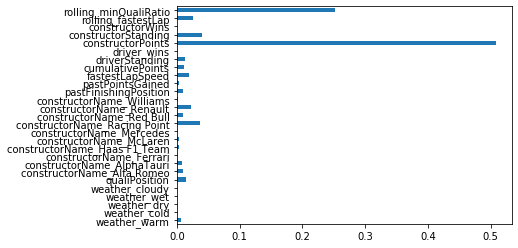

In [64]:
(pd.Series(xgb_model.feature_importances_, index=x_test.columns)
   .plot(kind='barh')) 

## Trying this with Standardized Data

In [74]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
x_train_scaled = scaler.fit_transform(x)
x_test_scaled = scaler.fit_transform(x_test)

# New Model with standardized Data
xgb_model.fit(x_train_scaled, y)
xgb_model.score(x_train_scaled, y)

0.9999999777748618

In [76]:
pd.DataFrame(x_train_scaled)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.166667,0.461538,0.611381,0.073171,0.15,0.0,0.131673,0.000000,0.166667,0.020478,0.001001
1,1.0,0.0,0.0,0.0,0.0,0.842105,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.277778,0.307692,0.576898,0.048780,0.25,0.0,0.028470,0.333333,0.000000,0.071715,0.662982
2,1.0,0.0,0.0,0.0,0.0,0.157895,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.961538,0.614599,0.152439,0.00,0.2,0.131673,0.000000,0.166667,0.015725,0.111263
3,1.0,0.0,0.0,0.0,0.0,0.631579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.611111,0.000000,0.529630,0.000000,0.55,0.0,0.021352,0.444444,0.000000,0.143430,0.503228
4,1.0,0.0,0.0,0.0,0.0,0.105263,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.384615,0.596069,0.060976,0.20,0.0,0.092527,0.111111,0.000000,0.043115,0.274409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,1.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.222222,0.384615,0.936900,0.713415,0.05,0.2,1.000000,0.000000,1.000000,0.076163,0.053364
111,1.0,0.0,0.0,0.0,0.0,0.578947,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444444,0.076923,0.910549,0.024390,0.70,0.0,0.167260,0.666667,0.166667,0.223120,0.515712
112,1.0,0.0,0.0,0.0,0.0,0.526316,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.461538,0.923076,0.347561,0.20,0.0,0.348754,0.222222,0.000000,0.151894,0.329609
113,1.0,0.0,0.0,0.0,0.0,0.894737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.722222,0.000000,0.913490,0.000000,1.00,0.0,0.000000,1.000000,0.000000,0.224783,0.607568


In [78]:
xgb_preds2 = xgb_model.predict(x_test_scaled)
xgb_preds_df2 = pd.DataFrame({'Predictions' : xgb_preds2})
merged_xgb_df2 = pd.merge(xgb_preds_df2, current_sorted_df[["raceId", "driverId"]], left_index = True, right_index = True)
full_xgb_df2 = pd.merge(merged_xgb_df2, drivers[["driverName", "driverId"]], on = "driverId")
full_xgb_df2 = full_xgb_df2.sort_values("Predictions")
full_xgb_df2 = full_xgb_df2.reset_index(drop = True)
full_xgb_df2["Predicted Position"] = full_xgb_df2.index + 1
full_xgb_df2.sort_values("Predictions")

,Predictions,raceId,driverId,driverName,Predicted Position
0,1.103371,1040,817,Daniel Ricciardo,1
1,1.526702,1040,822,Valtteri Bottas,2
2,1.896656,1040,1,Lewis Hamilton,3
3,3.318089,1040,815,Sergio Pérez,4
4,4.447368,1040,832,Carlos Sainz,5
5,4.489875,1040,848,Alexander Albon,6
6,4.515128,1040,840,Lance Stroll,7
7,4.622152,1040,846,Lando Norris,8
8,4.840340,1040,839,Esteban Ocon,9
9,5.103618,1040,830,Max Verstappen,10


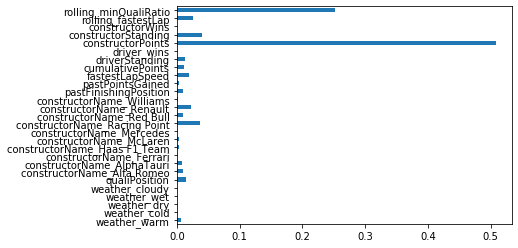

In [79]:
(pd.Series(xgb_model.feature_importances_, index=x_test.columns)
   .plot(kind='barh')) 